In [1]:
import numpy as np
import pandas as pd
import simplejson as json
import matplotlib.pylab as plt
import mpl_toolkits.basemap as bm
from scipy.stats.stats import pearsonr
import matplotlib.patches as mpatches
import argparse
import requests
import datetime
import dateutil
import logging
import twitter
import shutil
import errno
import time
import csv
import sys
import os

%matplotlib inline

In [17]:
TRAINING_SET_URL = "data/csv/BR20112012.csv"
df_brooklyn = pd.read_csv(TRAINING_SET_URL, sep=",")


In [18]:
from pprint import pprint
with open("data/json/BR20112012.json","r") as data_file:
    json_data = json.load(data_file)
    

In [19]:
ny_rental_data = dict()
with open("data/json/BR20112012.json","r") as data_file:
    brooklyn_json = json.load(data_file)
with open("data/json/QU20112012.json","r") as data_file:
    queens_json = json.load(data_file)
with open("data/json/MH20112012.json","r") as data_file:
    manhattan_json = json.load(data_file)
with open("data/json/SI20112012.json","r") as data_file:
    statenisland_json = json.load(data_file)
with open("data/json/BX20112012.json","r") as data_file:
    bronx_json = json.load(data_file)

In [20]:
ny_rental_data["booklyn"] = brooklyn_json["data"]
ny_rental_data["queens"]  = queens_json["data"]
ny_rental_data["manhattan"] = manhattan_json["data"]
ny_rental_data["statenisland"] = statenisland_json["data"]
ny_rental_data["bronx"] = bronx_json["data"]

In [21]:
total = 0
for district in ny_rental_data:
    total += len(ny_rental_data[district])
    print "%s :  %d" %(district,len(ny_rental_data[district]))
print "%s :  %d" % ("total", total)

bronx :  69
queens :  434
statenisland :  26
manhattan :  1381
booklyn :  717
total :  2627


In [22]:
brooklyn_nbh = list(set([ i[11] for i in ny_rental_data["booklyn"] ]))
queens_nbh = list(set([ i[11] for i in ny_rental_data["queens"] ]))
manhattan_nbh = list(set([ i[11] for i in ny_rental_data["manhattan"] ]))
statenisland_nbh = list(set([ i[11] for i in ny_rental_data["statenisland"] ]))
bronx_nbh = list(set([ i[11] for i in ny_rental_data["booklyn"]]))

In [23]:
print bronx_nbh

['KENSINGTON', 'PARK SLOPE SOUTH', 'COBBLE HILL-WEST', 'WILLIAMSBURG-CENTRAL', 'CLINTON HILL', 'COBBLE HILL', 'BAY RIDGE', 'CANARSIE', 'FLATBUSH-CENTRAL', 'FLATBUSH-LEFFERTS GARDEN', 'BENSONHURST', 'CARROLL GARDENS', 'FORT GREENE', 'DOWNTOWN-FULTON MALL', 'OCEAN HILL', 'WILLIAMSBURG-EAST', 'GRAVESEND', 'OCEAN PARKWAY-SOUTH', 'BUSHWICK', 'DOWNTOWN-METROTECH', 'BRIGHTON BEACH', 'SUNSET PARK', 'BROOKLYN HEIGHTS', 'WINDSOR TERRACE', 'DOWNTOWN-FULTON FERRY', 'MILL BASIN', 'BOERUM HILL', 'DYKER HEIGHTS', 'FLATBUSH-EAST', 'EAST NEW YORK', 'WYCKOFF HEIGHTS', 'WILLIAMSBURG-NORTH', 'BOROUGH PARK', 'MADISON', 'GREENPOINT', 'OCEAN PARKWAY-NORTH', 'BEDFORD STUYVESANT', 'PARK SLOPE', 'CROWN HEIGHTS', 'CONEY ISLAND', 'BATH BEACH', 'BUSH TERMINAL', 'PROSPECT HEIGHTS', 'MIDWOOD', 'FLATBUSH-NORTH', 'SHEEPSHEAD BAY', 'BERGEN BEACH', 'GOWANUS', 'WILLIAMSBURG-SOUTH']


In [24]:
def barh_plot(dataset,features_numbers,feature_names,figure_size=(10,15)):
    f1_data = [i[features_numbers[0]] for i in dataset] #Categorial data
    f2_data = [float(i[features_numbers[1]]) for i in dataset] #Numeric data
    data = [[f1_data[i],f2_data[i]] for i in xrange(0,len(f1_data))]
    
    data_df = pd.DataFrame(data,columns=(feature_names))
 
    plt.figure()
    plt.rcParams["figure.figsize"] = figure_size
    pl = data_df.groupby(feature_names[0]).mean().plot.barh(stacked=True,grid=True)
    pl.invert_yaxis()
    pl.xaxis.tick_top()
    plt.show()

In [25]:
def box_plot(dataset,features_numbers,feature_names,figure_size=(10,15)):
    f1_data = [i[features_numbers[0]] for i in dataset] #Categorial data
    f2_data = [float(i[features_numbers[1]]) for i in dataset] #Numeric data
    data = [[f1_data[i],f2_data[i]] for i in xrange(0,len(f1_data))]
    
    data_df = pd.DataFrame(data,columns=(feature_names))
 
    plt.figure()
    plt.rcParams["figure.figsize"] = figure_size
    pl = data_df.boxplot(vert=False, by=feature_names[0])
    pl.invert_yaxis()
    pl.xaxis.tick_top()

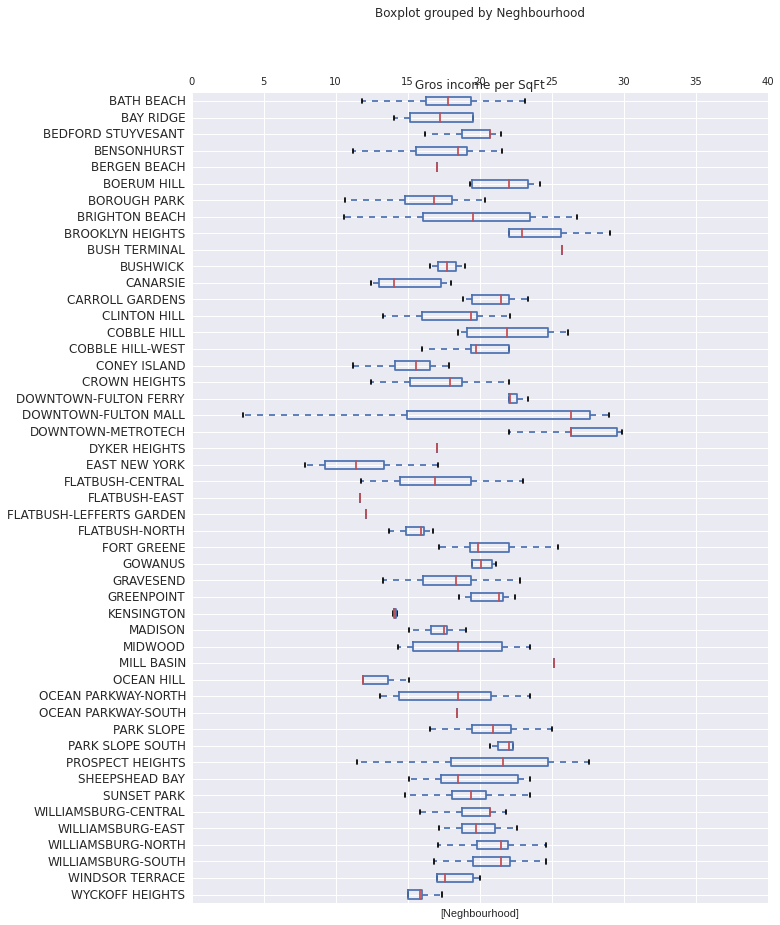

In [26]:
box_plot(ny_rental_data["booklyn"],[11,17],["Neghbourhood","Gros income per SqFt"])

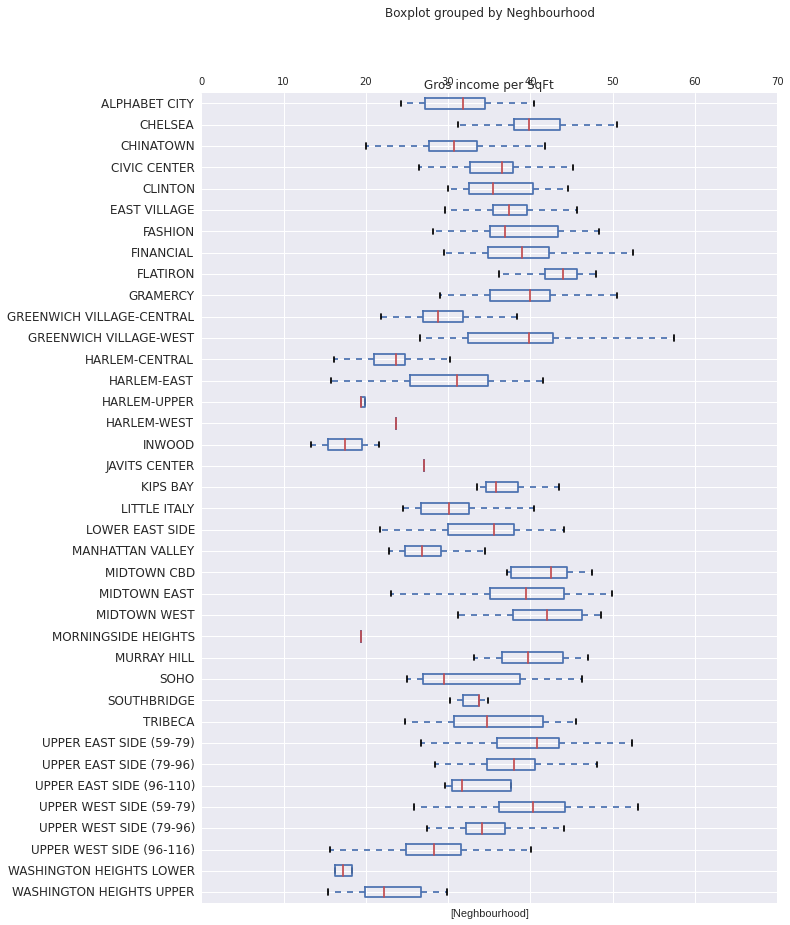

In [27]:
box_plot(ny_rental_data["manhattan"],[11,17],["Neghbourhood","Gros income per SqFt"])

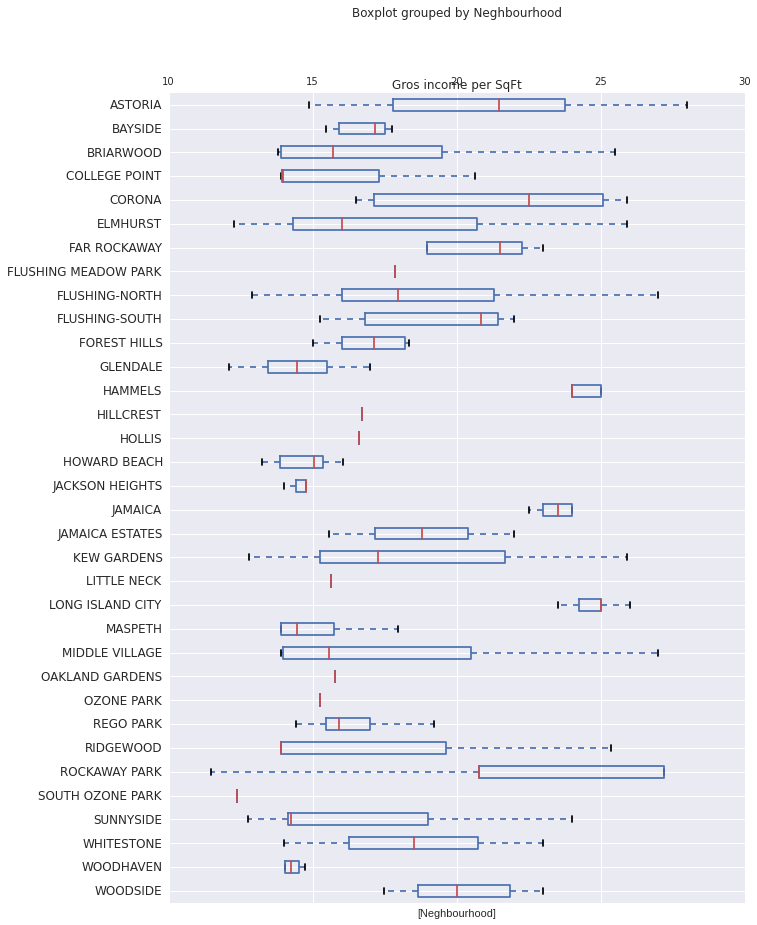

In [28]:
box_plot(ny_rental_data["queens"],[11,17],["Neghbourhood","Gros income per SqFt"])

In [29]:
#box_plot(ny_rental_data["booklyn"],[11,17],["Neghbourhood","Gros income per SqFt"])

In [30]:
def plot_correlation(dataset,features_numbers,feature_names,normalization=True):
    f1_data = [float(i[features_numbers[0]]) for i in dataset]
    f2_data = [float(i[features_numbers[1]]) for i in dataset]
    
    corr_data = [[f1_data[i],f2_data[i]] for i in xrange(0,len(f1_data))]
    corr_data = sorted(corr_data,key=lambda x: x[1],reverse=True)
    
    f1_sorted_data = [i[0] for i in corr_data]
    f2_sorted_data = [i[1] for i in corr_data]
    
    
    if normalization == True:
        f1_mean = np.mean(f1_sorted_data)
        f1_variance = np.sqrt(np.var(f1_sorted_data))
    
        f2_mean = np.mean(f2_sorted_data)
        f2_variance = np.sqrt(np.var(f2_sorted_data))
    
        f1_sorted_data = [(i - f1_mean)/f1_variance for i in f1_sorted_data]
        f2_sorted_data = [(i - f2_mean)/f2_variance for i in f2_sorted_data]
    
    plt.figure()
    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(f1_sorted_data,c='r',label=feature_names[0])
    plt.plot(f2_sorted_data,c='b',label=feature_names[1])
    plt.legend()
    plt.show()
    
    correlation = pearsonr(f1_sorted_data,f2_sorted_data)[0]
    print "Correlation between '%s' and '%s' is: %lf" %(feature_names[0],feature_names[1],correlation)

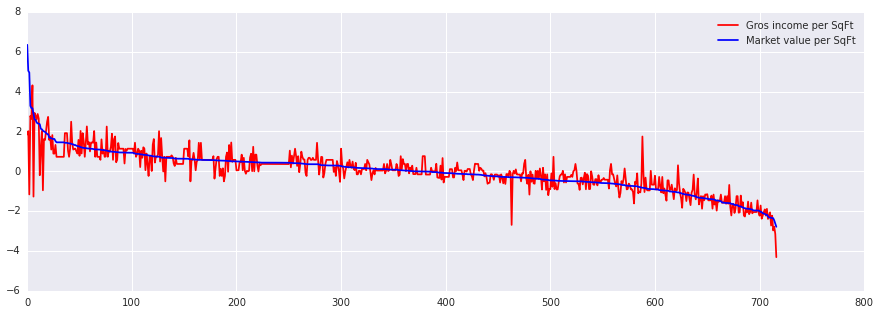

Correlation between 'Gros income per SqFt' and 'Market value per SqFt' is: 0.847969


In [34]:
plot_correlation(ny_rental_data["booklyn"],[17,22],["Gros income per SqFt","Market value per SqFt"])

In [35]:
ny_rental_data["booklyn"][0][12]

'R4-CONDOMINIUM'

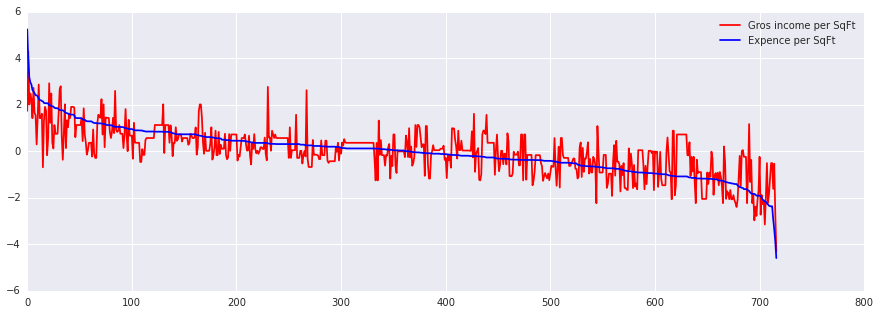

Correlation between 'Gros income per SqFt' and 'Expence per SqFt' is: 0.719317


In [36]:
plot_correlation(ny_rental_data["booklyn"],[17,19],["Gros income per SqFt","Expence per SqFt"])

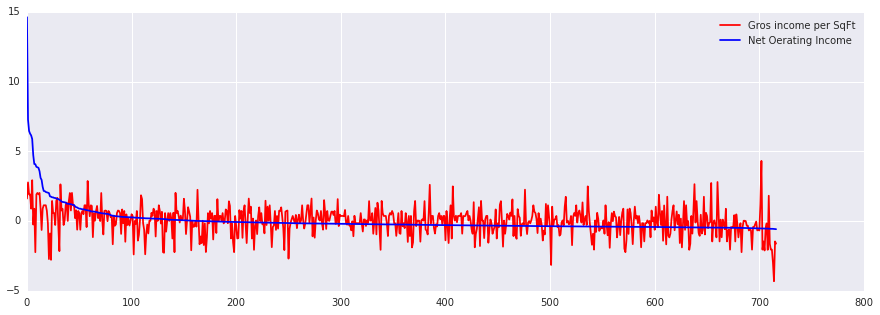

Correlation between 'Gros income per SqFt' and 'Net Oerating Income' is: 0.242706


In [37]:
plot_correlation(ny_rental_data["booklyn"],[17,20],["Gros income per SqFt","Net Oerating Income"])

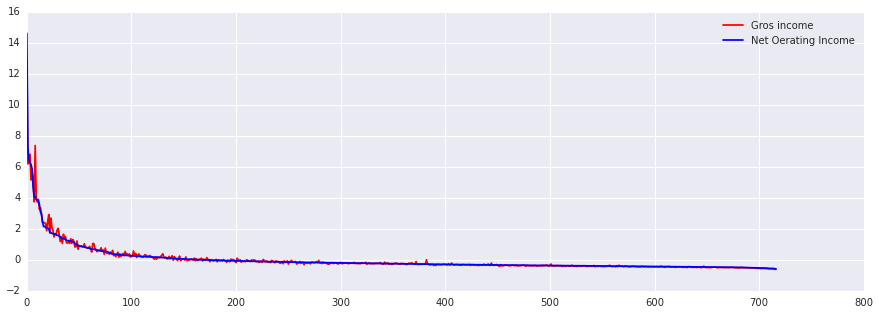

Correlation between 'Gros income' and 'Net Oerating Income' is: 0.984103


In [38]:
plot_correlation(ny_rental_data["booklyn"],[16,20],["Gros income","Net Oerating Income"])

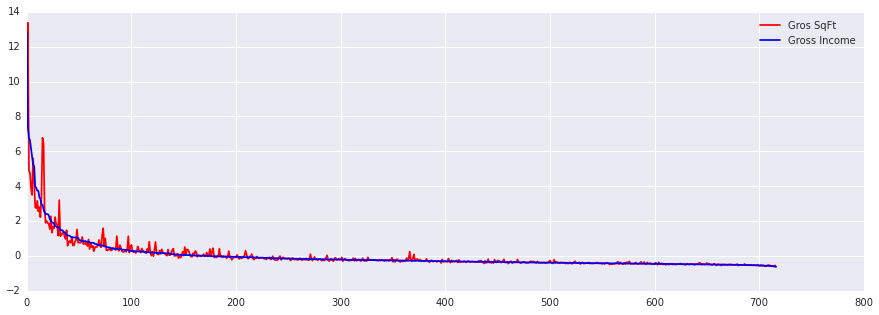

Correlation between 'Gros SqFt' and 'Gross Income' is: 0.920403


In [39]:
plot_correlation(ny_rental_data["booklyn"],[15,16],["Gros SqFt","Gross Income"])

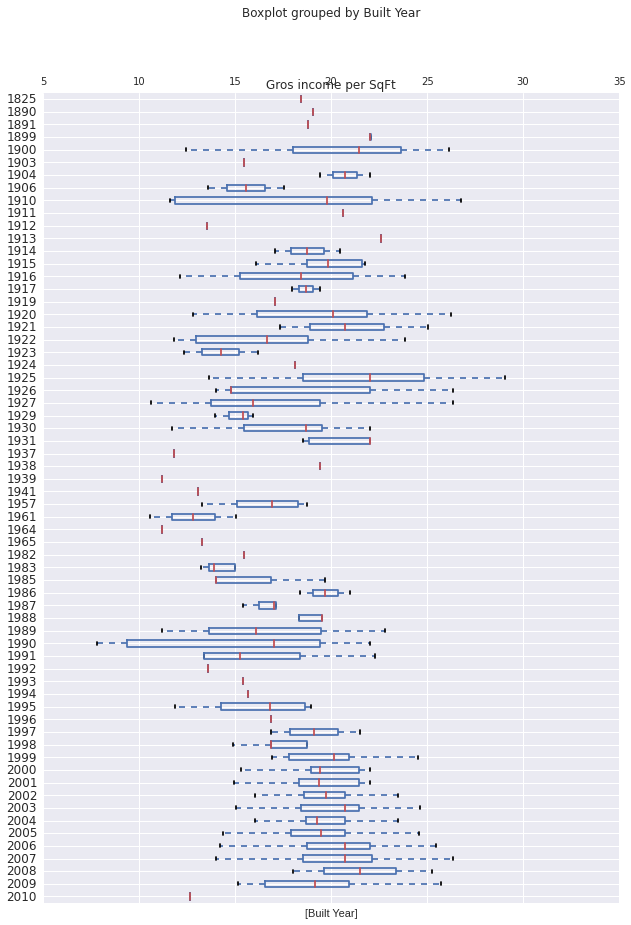

In [40]:
box_plot(ny_rental_data["booklyn"],[14,17],["Built Year","Gros income per SqFt"])

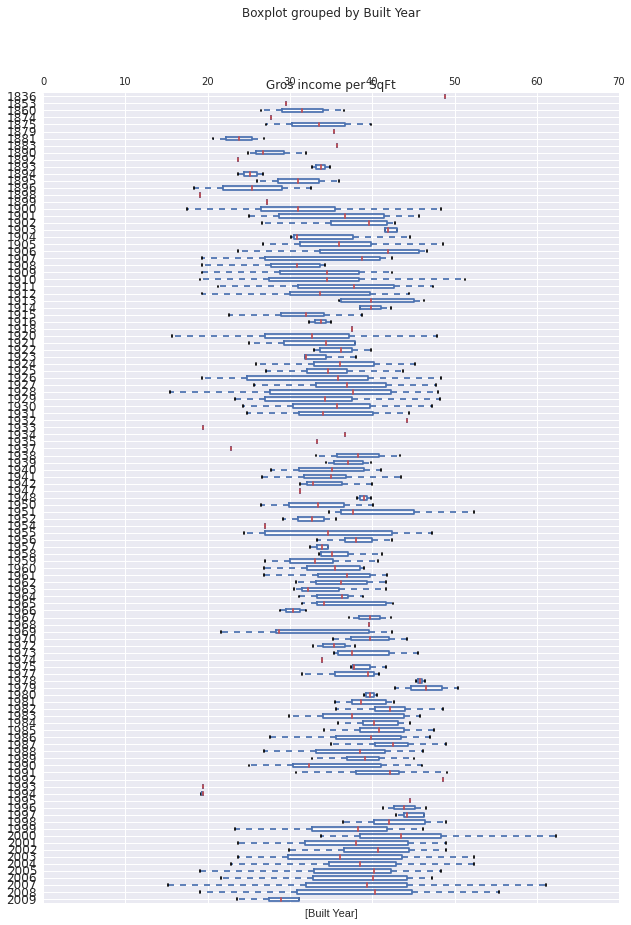

In [41]:
box_plot(ny_rental_data["manhattan"],[14,17],["Built Year","Gros income per SqFt"])

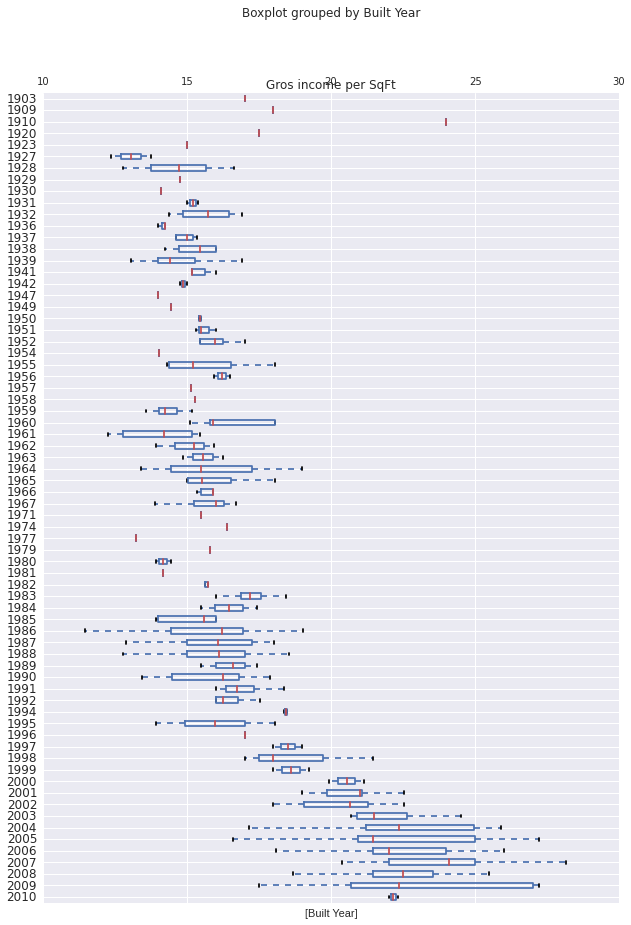

In [42]:
box_plot(ny_rental_data["queens"],[14,17],["Built Year","Gros income per SqFt"])

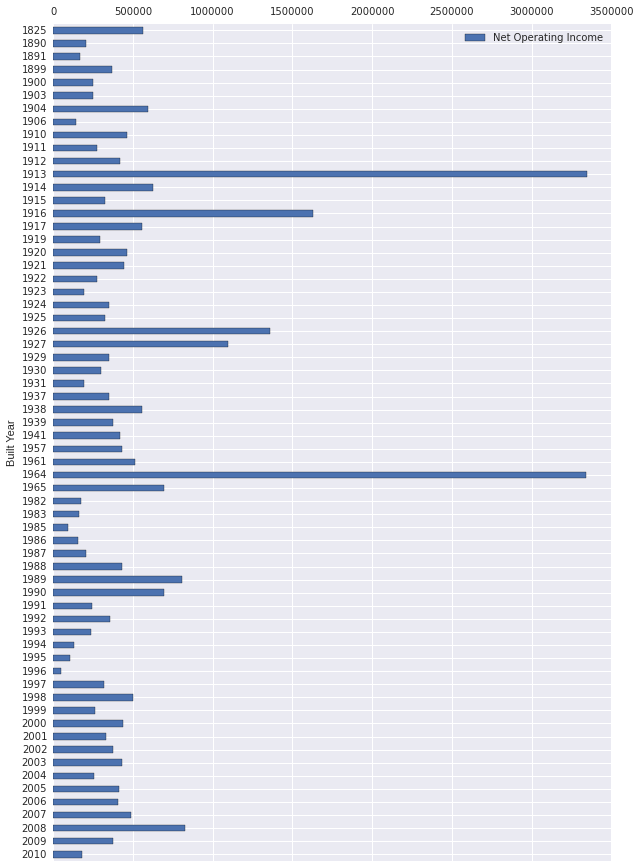

In [236]:
barh_plot(ny_rental_data["booklyn"],[14,20],["Built Year","Net Operating Income"])

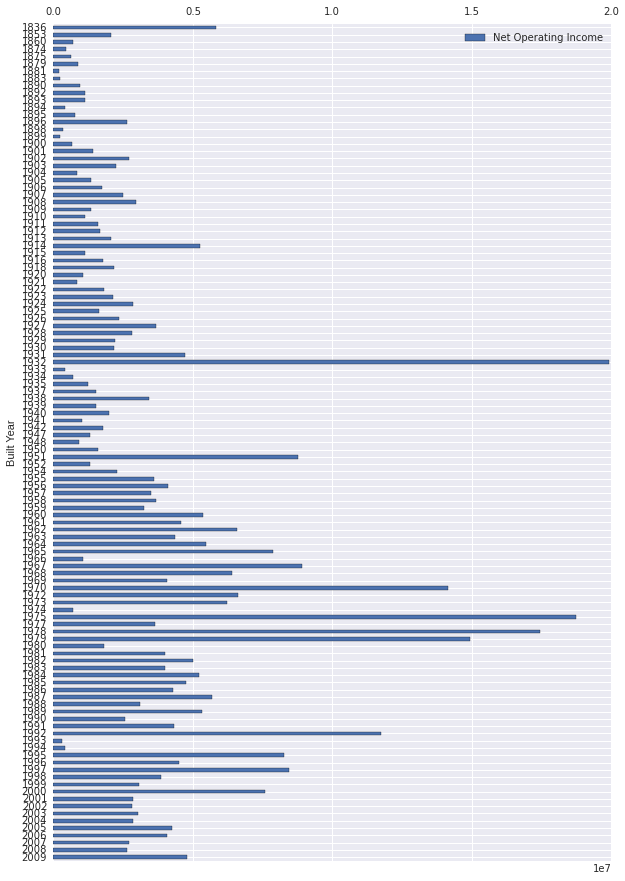

In [237]:
barh_plot(ny_rental_data["manhattan"],[14,20],["Built Year","Net Operating Income"])

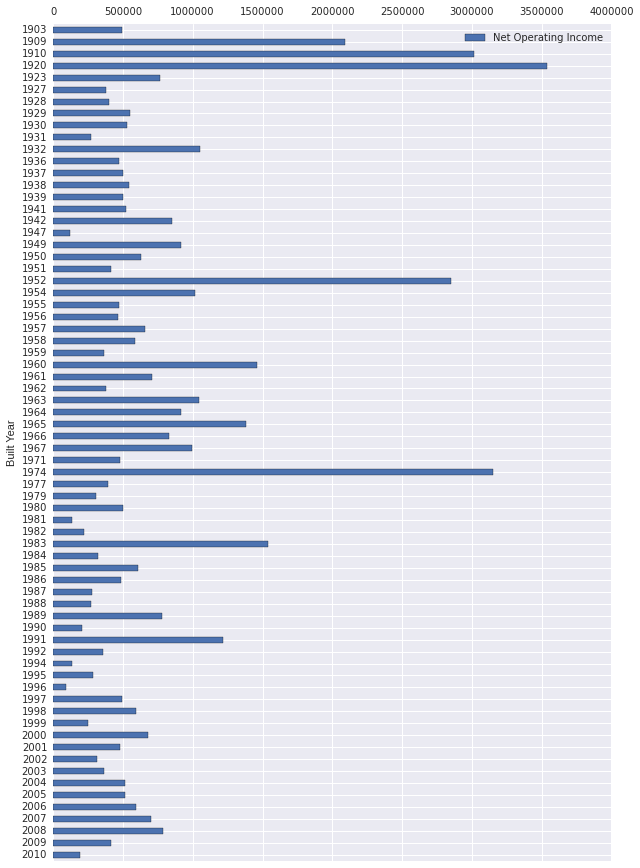

In [238]:
barh_plot(ny_rental_data["queens"],[14,20],["Built Year","Net Operating Income"])

In [239]:
def get_feature_percent_rate(dataset,feature_num,feature_name):
    f_values = list(set([i[feature_num] for i in dataset]))
    data_stat = dict()
    for val in f_values:
        data_stat[val] = 0.0
    for item in dataset:
        data_stat[item[feature_num]] += 1
    total = 0
    for val in data_stat:
        total += data_stat[val]
    for val in data_stat:
        data_stat[val] /= float(total)
    
    for val in data_stat:
        print "%s : %lf" %(val,data_stat[val])
        

In [16]:
def polar_chart_plot(dataset,feature_num,feature_name,figure_size=(5,5)):
    f_values = list(set([i[feature_num] for i in dataset]))
    data_stat = dict()
    for val in f_values:
        data_stat[val] = 0.0
    for item in dataset:
        data_stat[item[feature_num]] += 1
    total = 0
    for val in data_stat:
        total += data_stat[val]
    for val in data_stat:
        data_stat[val] /= float(total)
    
    labels = f_values
    sizes = [data_stat[i] for i in data_stat]

    plt.figure()
    plt.rcParams["figure.figsize"] = figure_size
    patches, texts = plt.pie(sizes,startangle=90)
    plt.legend(patches,labels,loc="best")
    plt.axis('equal')
    plt.legend()
    plt.show()

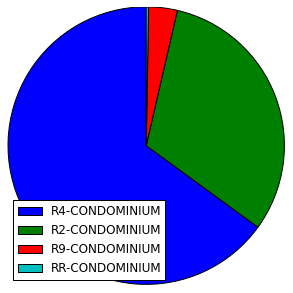

In [17]:
polar_chart_plot(ny_rental_data["booklyn"],12,"Building Classification")

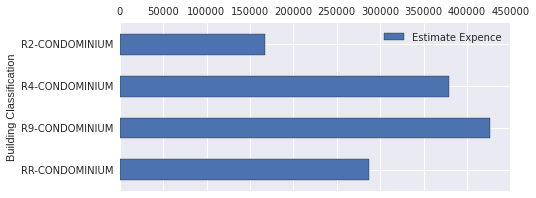

In [42]:
barh_plot(ny_rental_data["booklyn"],[12,18],["Building Classification","Estimate Expence"],figure_size=(7,3))

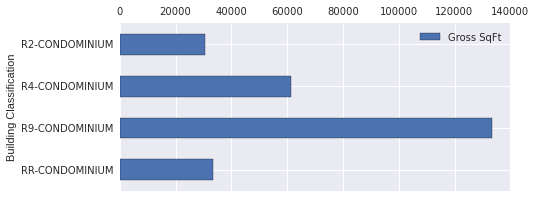

In [43]:
barh_plot(ny_rental_data["queens"],[12,15],["Building Classification","Gross SqFt"],figure_size=(7,3))

В Манхэтене:

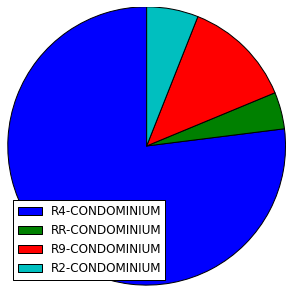

In [42]:
polar_chart_plot(ny_rental_data["manhattan"],12,"Building Classification")

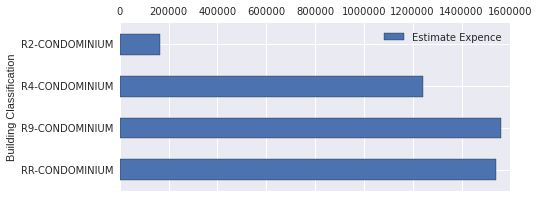

In [40]:
barh_plot(ny_rental_data["manhattan"],[12,18],["Building Classification","Estimate Expence"],figure_size=(7,3))

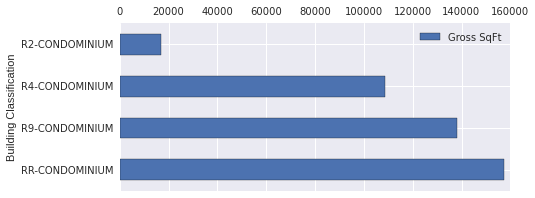

In [41]:
barh_plot(ny_rental_data["manhattan"],[12,15],["Building Classification","Gross SqFt"],figure_size=(7,3))

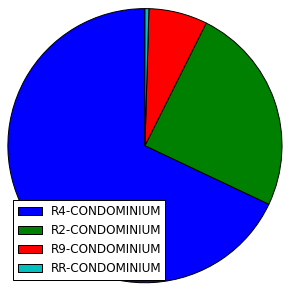

In [147]:
polar_chart_plot(ny_rental_data["queens"],12,"Building Classification")

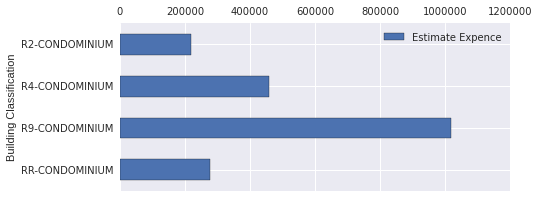

In [39]:
barh_plot(ny_rental_data["queens"],[12,18],["Building Classification","Estimate Expence"],figure_size=(7,3))

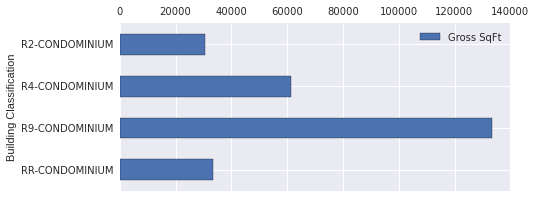

In [38]:
barh_plot(ny_rental_data["queens"],[12,15],["Building Classification","Gross SqFt"],figure_size=(7,3))

In [21]:
def plot_histogram(dataset,feature_num,feature_name,figure_size=(5,5)):
    f_values = sorted(list(set([i[feature_num] for i in dataset])))
    data_stat = dict()
    for val in f_values:
        data_stat[val] = 0.0
    for item in dataset:
        data_stat[item[feature_num]] += 1
    total = 0
    for val in data_stat:
        total += data_stat[val]
    for val in data_stat:
        data_stat[val] /= float(total)
        
    data_list = []    
    count = 0
    for val in data_stat:
        value = 0
        try:
            value = int(val)
        except:
            value = count
            count += 1
            
        data_list.append([value,data_stat[val]])
    data_list = sorted(data_list,key=lambda x: x[0])
    
    X = np.arange(0,len(data_list))
  
    plt.figure()
    plt.rcParams["figure.figsize"] = figure_size
    plt.bar(X,[i[1] for i in data_list],align='center',width=0.5)
    plt.xticks(X,[i[0] for i in data_list],rotation='vertical')
    ymax = max(data_stat.values()) 
    plt.ylim(0.0,ymax)
    plt.show()
    

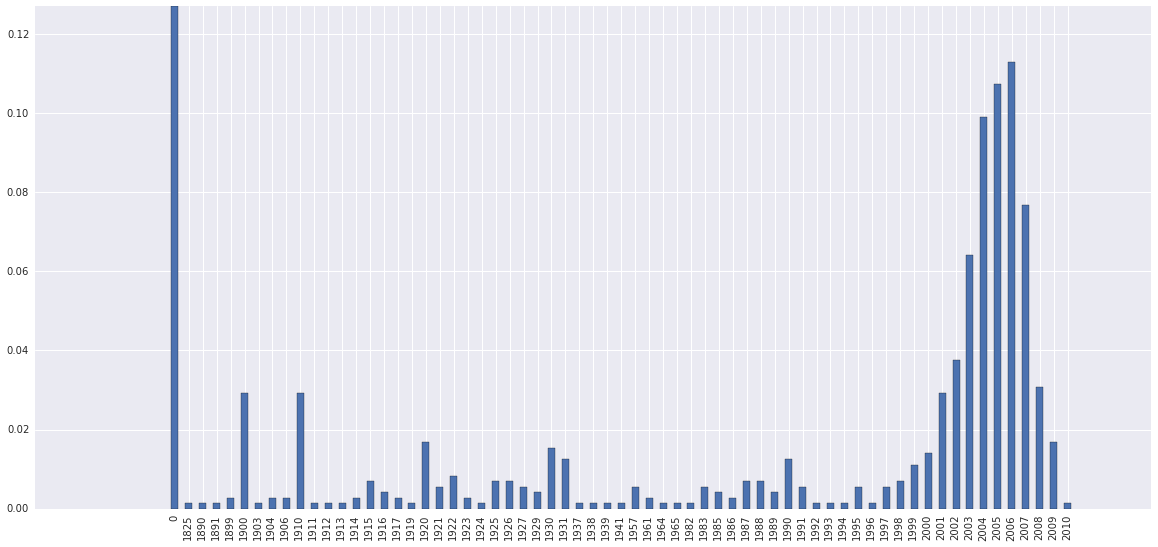

In [30]:
plot_histogram(ny_rental_data["booklyn"],14,"Built Year",figure_size=(20,9))

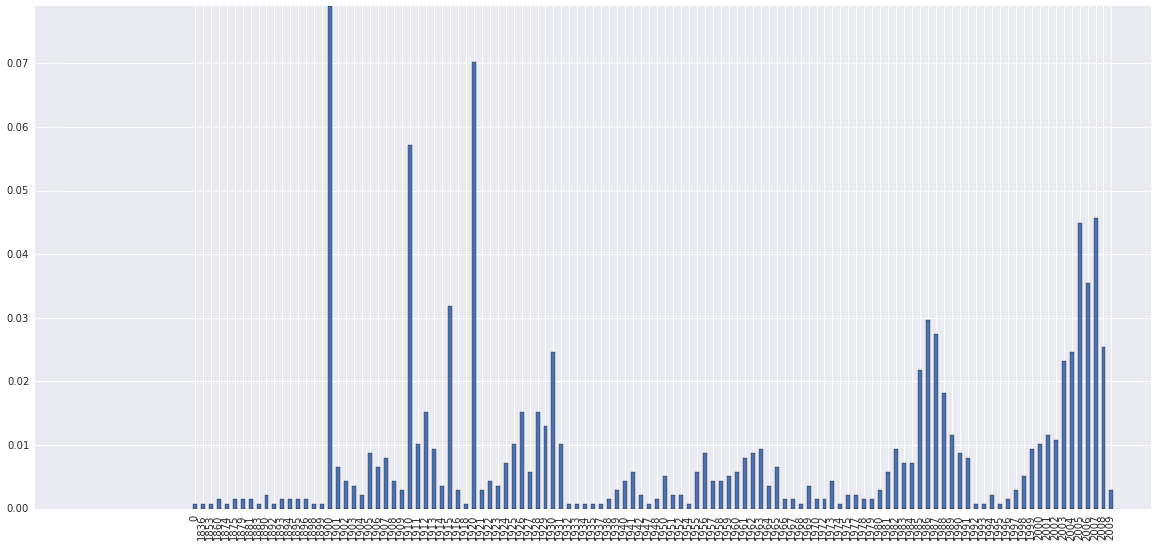

In [31]:
plot_histogram(ny_rental_data["manhattan"],14,"Built Year",figure_size=(20,9))

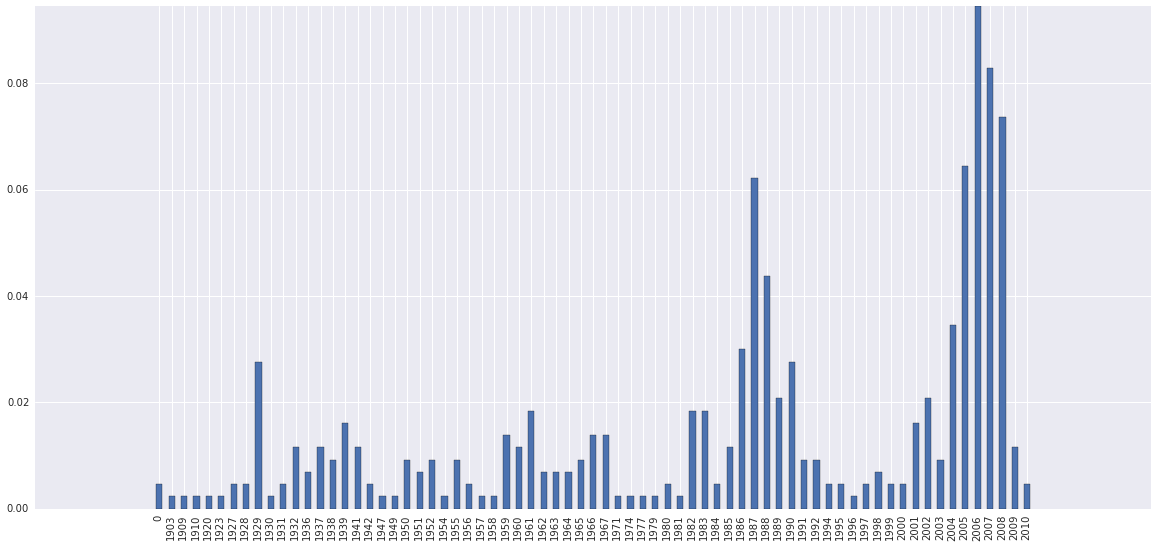

In [32]:
plot_histogram(ny_rental_data["queens"],14,"Built Year",figure_size=(20,9))

In [49]:
def print_prc(dataset,main_feature,extra_feature,figure_size=(10,15)):
    values_names =  sorted(list(set([i[main_feature] for i in dataset])))
    extra_names  =  sorted(list(set([i[extra_feature] for i in dataset])))
    
    data_stat = dict()
    for val in values_names:
        data_stat[val] = np.zeros(len(extra_names))
        
    count = 0
    for item in dataset:
        val = item[main_feature]
        index = extra_names.index(item[extra_feature])
        data_stat[val][index] += 1
        count += 1
        
    total = count
    
    for val in data_stat:
        data_stat[val] = data_stat[val]/float(total)
    
    for val in data_stat:
        print "%s: "%val
        for i in xrange(0,len(extra_names)):
            print "%s : %lf"%(extra_names[i],data_stat[val][i])

In [52]:
#print_prc(ny_rental_data["booklyn"],14,12) #Built Years vs Building Types

In [16]:
import pandas as pd
import string
import numpy as np
import itertools
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from scipy import stats
import matplotlib
import math

# Загрузка данных

In [55]:
def fix_columns(df):
    cols=list(df.columns)
    real_columns = ['COMPARABLE RENTAL 1 ']#[u'Boro-Block-Lot',u'Condo Section',u'Address',u'Neighborhood',u'Building Classification',\
                    #u'Total Units',u'Year Built',u'Gross SqFt',u'Est. Gross Income',u'Gross Income per SqFt',\
                    #u'Full Market Value',u'Market Value per SqFt',u'Boro-Block-Lot', u'Address',u'Neighborhood',\
                    #u'Building Classification',u'Total Units', u'Year Built',u'Gross SqFt',u'Est. Gross Income',\
                    #u'Gross Income per SqFt',u'Full Market Value',u'Market Value per SqFt',u'Dist. from Coop in miles',\
                    #u'Boro-Block-Lot', u'COMPARABLE RENTAL 2  Address',u'Neighborhood',u'Building Classification',\
                    #u'Total Units', u'COMPARABLE RENTAL 2  Year Built',u'Gross SqFt',u'Est. Gross Income',\
                    #u'Gross Income per SqFt',u'Full Market Value',u'Market Value per SqFt',u'Dist. from Coop in miles']
    to_remove = ['QUEENS CONDOMINIUM PROPERTY ', 'BRONX CONDOMINIUM PROPERTY ', 'BROOKLYN CONDOMINIUM PROPERTY ',\
                 'MANHATTAN CONDOMINIUM PROPERTY ', 'STATEN ISLAND CONDOMINIUM PROPERTY ',\
                'QUEENS CONDOMINIUMS COMPARABLE PROPERTIES ',\
                 'BRONX CONDOMINIUMS COMPARABLE PROPERTIES ','BROOKLYN CONDOMINIUMS COMPARABLE PROPERTIES ',\
                 'MANHATTAN CONDOMINIUMS COMPARABLE PROPERTIES ', 'STATEN ISLAND CONDOMINIUMS COMPARABLE PROPERTIES ']
    rental = 'COMPARABLE RENTAL '
    rm = []
    table = {}
    for c in cols:
        c_new = ' '.join(filter(lambda s: s!= '\xc3\xa2\xc2\x80\xc2\x93', c.split()))
        flag = True
        if flag:
            if c_new.startswith('COMPARABLE RENTAL 3'):
                rm.append(c)
        if flag:
            if c_new.startswith(rental):
                table[c] = ('RENTAL ' + c_new[len(rental):])
                flag = not flag
        if flag:
            for prefix in to_remove:
                if c_new.startswith(prefix):
                    table[c] = ('PROPERTY ' + c_new[len(prefix):])
                    flag = not flag
                    break
        if flag:    
            table[c] = c_new
    df = df.drop(rm, axis=1)
    df = df.rename(index=str, columns=table)
    return df

In [56]:
df = pd.DataFrame()
for i in range(2008, 2012):
    for j in ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten_Island']:
        new_df = pd.read_csv('Datasets/Condominium/%i_%i/DOF__Condominium_Comparable_Rental_Income___%s___FY_%i_%i.csv'\
        % (i, i+1, j, i, i+1))
        new_df['Year'] = i
        new_df['District'] = j

        
        df = pd.concat([df, fix_columns(new_df)], ignore_index=True)
        
        
        #DOF__Condominium_comparable_rental_Income___Bronx___FY_2010_2011.csv
        #DOF__Condominium_Comparable_Rental_Income___Bronx___FY_2010_2011.csv

In [57]:
for c in df.columns:
    if df[c].count() < 8000:
        df = df.drop([c], axis=1)
df.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8449 entries, 0 to 8448
Data columns (total 23 columns):
District                            8449 non-null object
PROPERTY Address                    8449 non-null object
PROPERTY Boro-Block-Lot             8449 non-null object
PROPERTY Building Classification    8449 non-null object
PROPERTY Condo Section              8449 non-null object
PROPERTY Full Market Value          8449 non-null int64
PROPERTY Gross Income per SqFt      8449 non-null float64
PROPERTY Gross SqFt                 8449 non-null int64
PROPERTY Market Value per SqFt      8448 non-null float64
PROPERTY Neighborhood               8449 non-null object
PROPERTY Total Units                8449 non-null int64
PROPERTY Year Built                 8353 non-null float64
RENTAL 1 Address                    8448 non-null object
RENTAL 1 Boro-Block-Lot             8449 non-null object
RENTAL 1 Building Classification    8449 non-null object
RENTAL 1 Full Market Value          84

In [58]:
df=df.dropna()
df.head(5)

District                                   PROPERTY Address  \
0    Bronx  717 KELLY STREET\nBronx, New York\n(40.8158575...   
1    Bronx  1209 NELSON AVENUE\nBronx, New York\n(40.83785...   
2    Bronx  3240 NETHERLAND AVENUE\nBronx, New York\n(40.8...   
3    Bronx  2718 SCHURZ AVENUE\nBronx, New York\n(40.81359...   
4    Bronx  720 217 STREET\nBronx, New York\n(40.881931979...   

  PROPERTY Boro-Block-Lot PROPERTY Building Classification  \
0            2-02686-7501                       R2-WALK-UP   
1            2-02516-7501                      R4-ELEVATOR   
2            2-05787-7501                      R4-ELEVATOR   
3            2-05604-7501                      R4-ELEVATOR   
4            2-04664-7501                       R2-WALK-UP   

  PROPERTY Condo Section  PROPERTY Full Market Value  \
0                  53-R1                      583003   
1                  73-R1                     1609988   
2                  30-R1                      760999   
3                  16-R1                     4000024   
4                  75-R1                     1310008   

   PROPERTY Gross Income per SqFt  PROPERTY Gross SqFt  \
0                           11.50                14384   
1                           16.33                24262   
2                           18.52                10108   
3                           15.50                63416   
4                           16.76                19225   

   PROPERTY Market Value per SqFt      PROPERTY Neighborhood  ...   \
0                            40.5        MORRISANIA/LONGWOOD  ...    
1                            66.0  HIGHBRIDGE/MORRIS HEIGHTS  ...    
2                            75.0                  RIVERDALE  ...    
3                            63.0                THROGS NECK  ...    
4                            68.0             WILLIAMSBRIDGE  ...    

   RENTAL 1 Boro-Block-Lot  RENTAL 1 Building Classification  \
0             2-02427-0001                        C7-WALK-UP   
1             2-02474-0051                        C1-WALK-UP   
2             2-03145-0025                        C1-WALK-UP   
3             2-03142-0200                       D1-ELEVATOR   
4             2-03740-0052                        C1-WALK-UP   

  RENTAL 1 Full Market Value RENTAL 1 Gross Income per SqFt  \
0                     395000                          10.58   
1                    1190000                          16.47   
2                     360000                          13.52   
3                    4880000                          18.25   
4                     612000                           9.67   

  RENTAL 1 Gross SqFt  RENTAL 1 Market Value per SqFt  RENTAL 1 Neighborhood  \
0               11055                            35.7      MELROSE/CONCOURSE   
1               17750                            67.0      MELROSE/CONCOURSE   
2                9424                            38.2                FORDHAM   
3               94682                            52.0                FORDHAM   
4               18720                            32.7              SOUNDVIEW   

   RENTAL 1 Total Units  RENTAL 1 Year Built  Year  
0                    16                 1923  2008  
1                    20                 1910  2008  
2                    16                 1925  2008  
3                    99                 1972  2008  
4                    25                 1926  2008  

[5 rows x 23 columns]

In [59]:
df.to_csv('condominium.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8351 entries, 0 to 8448
Data columns (total 23 columns):
District                            8351 non-null object
PROPERTY Address                    8351 non-null object
PROPERTY Boro-Block-Lot             8351 non-null object
PROPERTY Building Classification    8351 non-null object
PROPERTY Condo Section              8351 non-null object
PROPERTY Full Market Value          8351 non-null int64
PROPERTY Gross Income per SqFt      8351 non-null float64
PROPERTY Gross SqFt                 8351 non-null int64
PROPERTY Market Value per SqFt      8351 non-null float64
PROPERTY Neighborhood               8351 non-null object
PROPERTY Total Units                8351 non-null int64
PROPERTY Year Built                 8351 non-null float64
RENTAL 1 Address                    8351 non-null object
RENTAL 1 Boro-Block-Lot             8351 non-null object
RENTAL 1 Building Classification    8351 non-null object
RENTAL 1 Full Market Value          83

# Проверка статистических гипотез

In [60]:
df.groupby('District').mean()

PROPERTY Full Market Value  PROPERTY Gross Income per SqFt  \
District                                                                    
Bronx                        8.198825e+06                       14.195907   
Brooklyn                     3.180694e+06                       18.545637   
Manhattan                    2.055415e+07                       34.282893   
Queens                       4.151240e+06                       17.740827   
Staten_Island                3.165156e+06                        6.218542   

               PROPERTY Gross SqFt  PROPERTY Market Value per SqFt  \
District                                                             
Bronx                240537.046414                       50.763291   
Brooklyn              40054.782843                       81.101176   
Manhattan            114231.795945                      167.084625   
Queens                62911.063338                       71.381446   
Staten_Island         80956.687500                       39.809062   

               PROPERTY Total Units  PROPERTY Year Built  \
District                                                   
Bronx                    237.320675          1971.367089   
Brooklyn                  76.644608          1759.053922   
Manhattan                 93.808024          1941.921700   
Queens                    64.119970          1932.971684   
Staten_Island             78.989583          1548.395833   

               RENTAL 1 Full Market Value  RENTAL 1 Gross Income per SqFt  \
District                                                                    
Bronx                        3.412865e+06                       13.778945   
Brooklyn                     2.719538e+06                       20.194765   
Manhattan                    2.394212e+07                       36.664062   
Queens                       4.311484e+06                       17.916028   
Staten_Island                3.432448e+06                       12.786354   

               RENTAL 1 Gross SqFt  RENTAL 1 Market Value per SqFt  \
District                                                             
Bronx                 74840.308017                       44.556456   
Brooklyn              34228.954412                       77.045828   
Manhattan            126587.916954                      179.352552   
Queens                65241.362146                       70.575000   
Staten_Island         93324.312500                       40.776667   

               RENTAL 1 Total Units  RENTAL 1 Year Built         Year  
District                                                               
Bronx                     69.894515          1950.464135  2009.658228  
Brooklyn                  39.215196          1942.656373  2009.711275  
Manhattan                126.105047          1951.229508  2009.625324  
Queens                    71.824143          1973.789121  2009.719821  
Staten_Island            105.072917          1965.875000  2009.500000

In [61]:
df.mean()

PROPERTY Full Market Value        1.312365e+07
PROPERTY Gross Income per SqFt    2.688758e+01
PROPERTY Gross SqFt               9.106647e+04
PROPERTY Market Value per SqFt    1.259367e+02
PROPERTY Total Units              8.874698e+01
PROPERTY Year Built               1.892124e+03
RENTAL 1 Full Market Value        1.478481e+07
RENTAL 1 Gross Income per SqFt    2.870415e+01
RENTAL 1 Gross SqFt               9.231695e+04
RENTAL 1 Market Value per SqFt    1.314619e+02
RENTAL 1 Total Units              9.431948e+01
RENTAL 1 Year Built               1.952907e+03
Year                              2.009661e+03
dtype: float64

## 1) Простая гипотеза

### 1.1) Зависит ли площадь от того, арендуется или покупается недвижимость?
$$H_0: S_{rental} \neq S_{property}$$
$$H_1: S_{rental} = S_{property}$$

In [62]:
alpha = 0.05
rent = df['RENTAL 1 Gross SqFt']
prop = df['PROPERTY Gross SqFt']
print "%s гипотеза верна" %("Нулевая" if stats.ttest_ind(prop, rent)[1] > alpha else "Альтернативная")

Нулевая гипотеза верна


### 1.2) Зависит ли площадь от района?
$$H_0: S_{district_1} \neq S_{district_2}$$
$$H_1: S_{district_1} = S_{district_2}$$

In [63]:
alpha = 0.05
rent = df['RENTAL 1 Gross SqFt']
prop = df['PROPERTY Gross SqFt']
print "%s гипотеза верна" %("Нулевая" if stats.ttest_ind(prop, rent)[1] > alpha else "Альтернативная")

Нулевая гипотеза верна


In [64]:
dstr = df["District"].unique()
m = pd.DataFrame(index=dstr, columns=dstr)
for d1 in dstr:
    for d2 in dstr:
        m[d1][d2] = "Not equal" if (stats.ttest_ind(pd.concat([rent[df.District == d1], prop[df.District == d1]], ignore_index=True),\
                                                    pd.concat([rent[df.District == d2], prop[df.District == d2]], ignore_index=True))[1] < alpha) else "Equal"
m

Bronx   Brooklyn  Manhattan     Queens Staten_Island
Bronx              Equal  Not equal  Not equal  Not equal         Equal
Brooklyn       Not equal      Equal  Not equal  Not equal     Not equal
Manhattan      Not equal  Not equal      Equal  Not equal     Not equal
Queens         Not equal  Not equal  Not equal      Equal     Not equal
Staten_Island      Equal  Not equal  Not equal  Not equal         Equal

## 2) Сложная гипотеза: критерий согласия 

In [1]:
import pandas as pd
import numpy as np
import twitter
import matplotlib.pyplot as plt
import csv
#import time
import sys
import re
import requests
import json
import time
import sys
import seaborn as sns

# Plotting config
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('condominium.csv', sep=',')

In [3]:
processed_locs = {}
def get_coords_by_address(address):
    address.replace(' ', '+')
    request = 'http://maps.google.com/maps/api/geocode/json?address='+address+'&sensor=false'
    try:
        r = requests.get(request)
        j = json.loads(r.content)
        respond = j['results'][0]['geometry']
        if (j['status']=='OVER_QUERY_LIMIT'):
            print "Sleeping for 2 sec"
            time.sleep(2)
            j = json.loads(r.content)
        loc = (respond['location']['lat'], respond['location']['lng'], respond['location_type'])
        return loc
    except Exception as e:
        print e
        print j
        if (j['status']=='OVER_QUERY_LIMIT'):
            try:
                print "Sleeping for 2 sec"
                time.sleep(2)
                r = requests.get(request)
                j = json.loads(r.content)
                respond = j['results'][0]['geometry']
                loc = (respond['location']['lat'], respond['location']['lng'], respond['location_type'])
                return loc
            except Exception as e:
                print "2 exc"
                print j
                return (0, 0, 'null')
    

In [7]:
addresses = df['PROPERTY Address']

In [ ]:
lat, lng = map(float, addresses[0].split('\n')[2].strip('()').split(','))

In [29]:
len(addresses)

8351

In [ ]:
coords = []
for i in xrange(len(addresses)):
    spl = addresses[i].split('\n')
    sys.stdout.write('\rAddr %.5f ' % (float(i)/len(addresses)))
    try:
        if len(spl)>2:
            lat, lng = map(float, spl[2].strip('()').split(','))
        if df['District'][i]=='Manhattan' or df['District'][i]=='Queens':
            print addresses[i]
            lat, lng = get_coords_by_address(addresses[i])
        if lat==0 and lng==0:
            continue
        coords.append([i, lat, lng])
    except Exception as e:
        continue

In [34]:
len(coords)

7327

In [35]:
a = np.array(coords)

In [36]:
image = plt.imread('new_york.png')

In [37]:
#ind = a[:,1]
ind = a[:,2]>-74.2
b = a[ind==True]
x = b[:,2]
y = b[:,1]

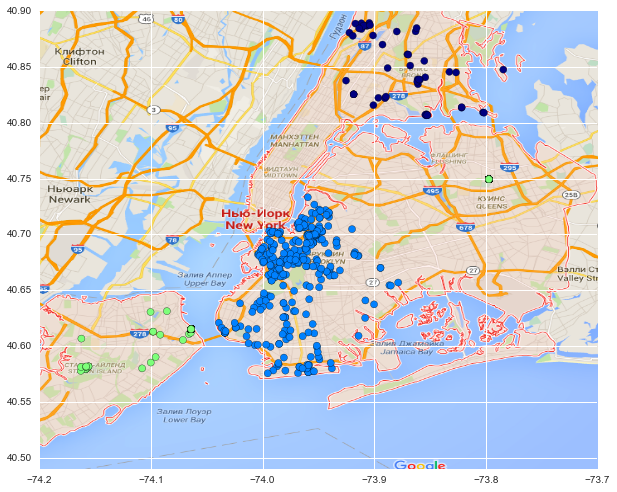

In [107]:
plt.figure(figsize=(10, 10))
plt.xlim([-74.2, -73.7])
plt.ylim([40.49, 40.9])
plt.scatter(x, y, c=colors, cmap=CM.jet, s=50)
img_bounds = (-74.272950,-73.694915, 40.489464,  40.938429)
plt.imshow(image, extent=img_bounds)
plt.show()


In [90]:
df.columns

Index([u'Unnamed: 0', u'District', u'PROPERTY Address',
       u'PROPERTY Boro-Block-Lot', u'PROPERTY Building Classification',
       u'PROPERTY Condo Section', u'PROPERTY Full Market Value',
       u'PROPERTY Gross Income per SqFt', u'PROPERTY Gross SqFt',
       u'PROPERTY Market Value per SqFt', u'PROPERTY Neighborhood',
       u'PROPERTY Total Units', u'PROPERTY Year Built', u'RENTAL 1 Address',
       u'RENTAL 1 Boro-Block-Lot', u'RENTAL 1 Building Classification',
       u'RENTAL 1 Full Market Value', u'RENTAL 1 Gross Income per SqFt',
       u'RENTAL 1 Gross SqFt', u'RENTAL 1 Market Value per SqFt',
       u'RENTAL 1 Neighborhood', u'RENTAL 1 Total Units',
       u'RENTAL 1 Year Built', u'Year'],
      dtype='object')

In [91]:
areas = df['District']
areas = areas[ind==True]

C:\Users\denilv\Anaconda2\lib\site-packages\pandas\core\internals.py:215: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 8351 but corresponding boolean dimension is 7327
  return self.values[slicer]
C:\Users\denilv\Anaconda2\lib\site-packages\pandas\indexes\base.py:1267: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 8351 but corresponding boolean dimension is 7327
  result = getitem(key)


In [96]:
cmap = np.unique(areas)
d = dict(zip(cmap,arange(len(cmap))))
colors = []
for i in areas:
    colors.append(d[i])

In [ ]:
plt.figure(figsize=(10, 10))
plt.xlim([-74.2, -73.7])
plt.ylim([40.49, 40.9])
plt.scatter(x, y)
img_bounds = (-74.272950,-73.694915, 40.489464,  40.938429)
plt.imshow(image, extent=img_bounds)
plt.show()


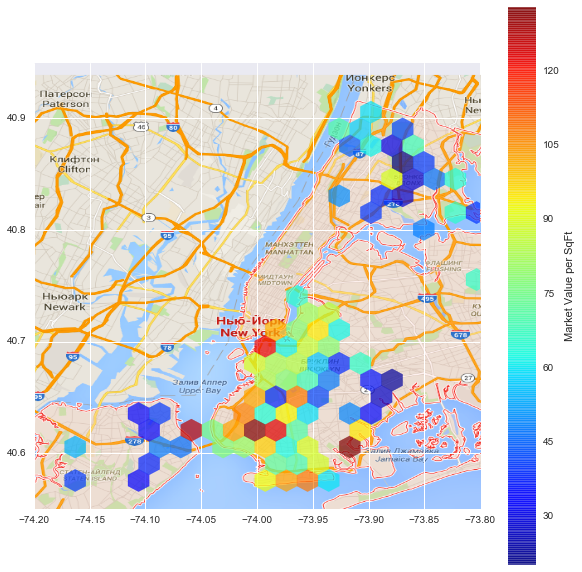

In [25]:
name = 'Market Value per SqFt'
values = df['PROPERTY ' + name]
values = np.array(values)
values = np.take(values, b[:,0].astype(int))
from matplotlib import cm as CM
from matplotlib import mlab as ML
plt.figure(figsize=(10, 10))
plt.hexbin(x, y, C=values, gridsize=20, cmap=CM.jet, bins=None, alpha=0.7)
plt.axis([-74.2, -73.8, 40.55, 40.95])
cb = plt.colorbar()
cb.set_label(name)
plt.imshow(image, extent=img_bounds)
plt.show()   

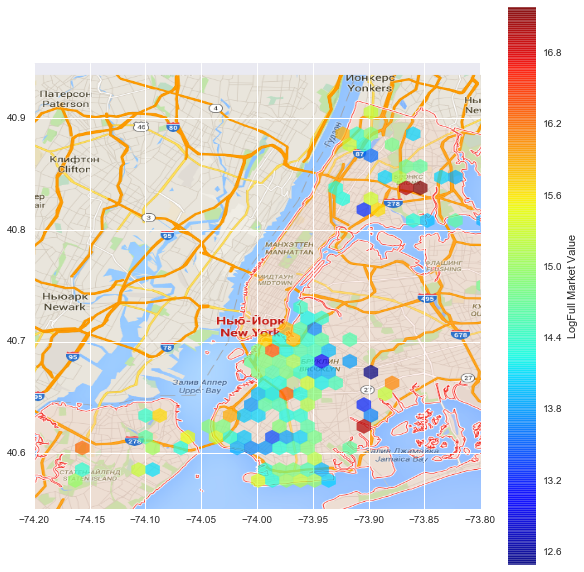

In [85]:
name = 'Full Market Value'
values = df['PROPERTY ' + name]
values = np.array(values)
values = np.take(values, b[:,0].astype(int))
values = np.log(values)
from matplotlib import cm as CM
from matplotlib import mlab as ML
plt.figure(figsize=(10, 10))
plt.hexbin(x, y, C=values, gridsize=30, cmap=CM.jet, bins=None, alpha=0.7)
plt.axis([-74.2, -73.8, 40.55, 40.95])
cb = plt.colorbar()
cb.set_label('Log' + name)
plt.imshow(image, extent=img_bounds)
plt.show()   

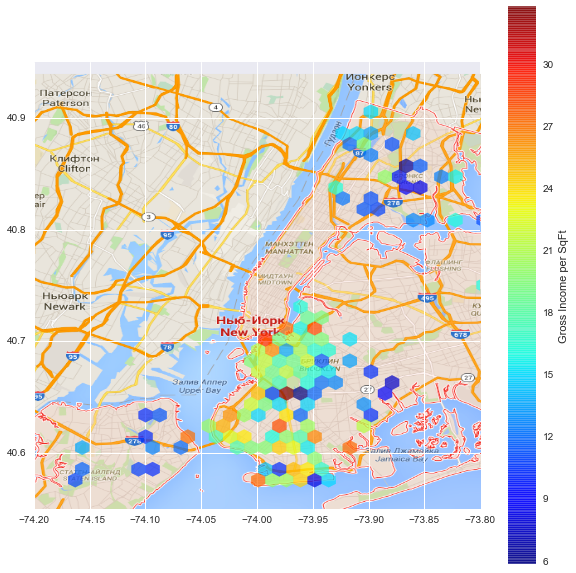

In [62]:
name = 'Gross Income per SqFt'
values = df['PROPERTY ' + name]
values = np.array(values)
values = np.take(values, b[:,0].astype(int))
from matplotlib import cm as CM
from matplotlib import mlab as ML
plt.figure(figsize=(10, 10))
plt.hexbin(x, y, C=values, gridsize=30, cmap=CM.jet, bins=None, alpha=0.7)
plt.axis([-74.2, -73.8, 40.55, 40.95])
cb = plt.colorbar()
cb.set_label(name)
plt.imshow(image, extent=img_bounds)
plt.show()   

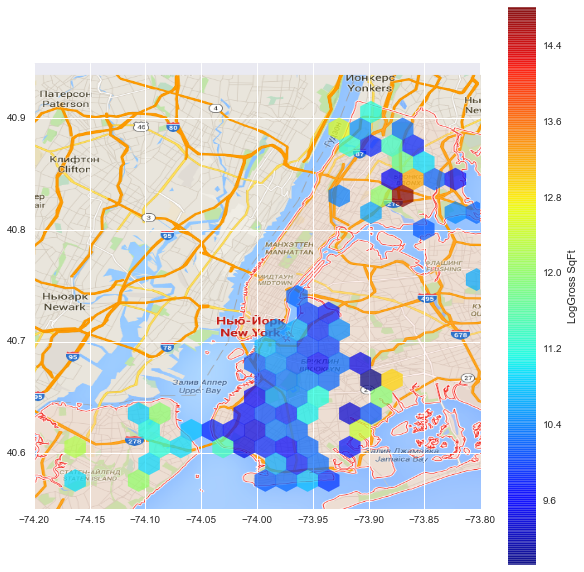

In [82]:
name = 'Gross SqFt'
values = df['PROPERTY ' + name]
values = np.array(values)
values = np.take(values, b[:,0].astype(int))
values = np.log(values)
from matplotlib import cm as CM
from matplotlib import mlab as ML
plt.figure(figsize=(10, 10))
plt.hexbin(x, y, C=values, gridsize=20, cmap=CM.jet, bins=None, alpha=0.7)
plt.axis([-74.2, -73.8, 40.55, 40.95])
cb = plt.colorbar()
cb.set_label('Log' + name)
plt.imshow(image, extent=img_bounds)
plt.show()   

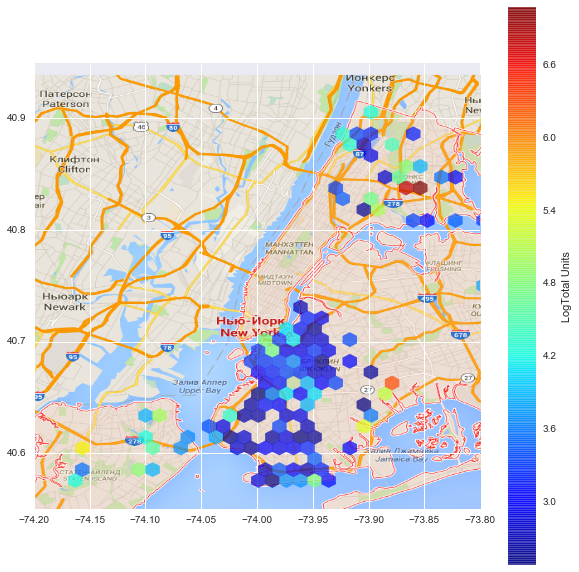

In [86]:
name = 'Total Units'
values = df['PROPERTY ' + name]
values = np.array(values)
values = np.take(values, b[:,0].astype(int))
values = np.log(values)
from matplotlib import cm as CM
from matplotlib import mlab as ML
plt.figure(figsize=(10, 10))
plt.hexbin(x, y, C=values, gridsize=30, cmap=CM.jet, bins=None, alpha=0.7)
plt.axis([-74.2, -73.8, 40.55, 40.95])
cb = plt.colorbar()
cb.set_label('Log' + name)
plt.imshow(image, extent=img_bounds)
plt.show()   

### 2.1) Доход с квадратного фута распределен так же, как и стоимость квадратного фута

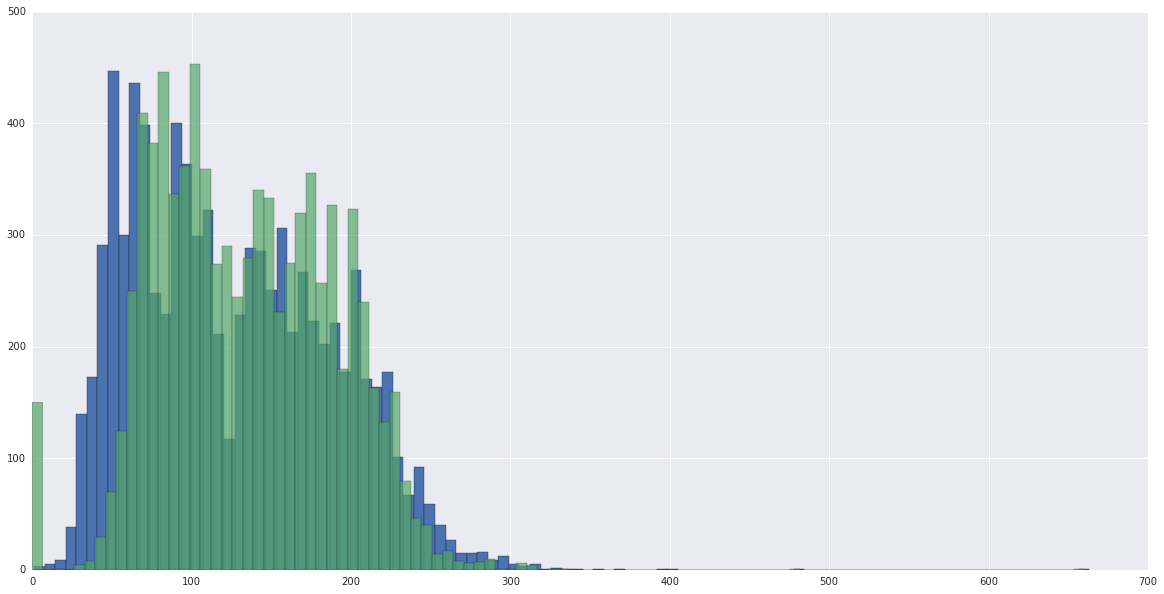

In [65]:
plt.figure(figsize=(20,10))
df['PROPERTY Market Value per SqFt'].hist(bins=100)
(df['PROPERTY Gross Income per SqFt'] * 5).hist(bins=100, alpha=.7)
plt.savefig('rent.png')

In [69]:
coef = stats.pearsonr(pd.concat([df['PROPERTY Market Value per SqFt'], df['RENTAL 1 Market Value per SqFt']], ignore_index=True),\
            pd.concat([df['PROPERTY Gross Income per SqFt'], df['RENTAL 1 Gross Income per SqFt']], ignore_index=True))
coef

(0.950449663750633, 0.0)

In [68]:
alpha = 0.01

print "Данные сильно скоррелированы" if coef[1] < alpha else "Данные слабо скоррелированы"

Данные сильно скоррелированы


In [71]:
stats.shapiro(pd.concat([df['PROPERTY Market Value per SqFt'], df['RENTAL 1 Market Value per SqFt']], ignore_index=True))

(0.9530413150787354, 0.0)

In [73]:
for c in df.columns:
    try:
        print c, stats.shapiro(df[c])
    except:
        continue

 District PROPERTY Address PROPERTY Boro-Block-Lot PROPERTY Building Classification PROPERTY Condo Section PROPERTY Full Market Value (0.5490279197692871, 0.0)
PROPERTY Gross Income per SqFt (0.9780145287513733, 5.808397226498724e-34)
PROPERTY Gross SqFt (0.3969481587409973, 0.0)
PROPERTY Market Value per SqFt (0.959919810295105, 5.675258780515509e-43)
PROPERTY Neighborhood PROPERTY Total Units (0.01969468593597412, 0.0)
PROPERTY Year Built (0.2617639899253845, 0.0)
RENTAL 1 Address RENTAL 1 Boro-Block-Lot RENTAL 1 Building Classification RENTAL 1 Full Market Value (0.5506508350372314, 0.0)
RENTAL 1 Gross Income per SqFt (0.9634772539138794, 1.6640419263857203e-41)
RENTAL 1 Gross SqFt (0.5347134470939636, 0.0)
RENTAL 1 Market Value per SqFt (0.9453558325767517, 0.0)
RENTAL 1 Neighborhood RENTAL 1 Total Units (0.5716317892074585, 0.0)
RENTAL 1 Year Built (0.8993226885795593, 0.0)
Year (0.8428319692611694, 0.0)


Нормально распределенное величины:
- Gross Income per SqFt
- Market Value per SqFt